# DATA EXPLORATION NOTEBOOK

### **1. Import thư viện và tải dữ liệu**

**Import thư viện**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

**Cấu hình**

In [20]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

**Lấy dữ liệu từ file**

In [21]:
df = pd.read_csv('football_players_dataset.csv')

# Tạo backup để có thể quay lại dữ liệu gốc
df_original = df.copy()

print(f"Load dữ liệu thành công!")
print(f"Kích thước dữ liệu: {df.shape[0]:,} dòng x {df.shape[1]} cột")

Load dữ liệu thành công!
Kích thước dữ liệu: 11,266 dòng x 36 cột


### **2. Ý nghĩa từng cột dữ liệu**

In [22]:
column_descriptions = {
    # Thông tin cơ bản
    'player_id': 'ID duy nhất của cầu thủ',
    'player_name': 'Tên cầu thủ',
    'age': 'Tuổi của cầu thủ (năm)',
    'nationality': 'Quốc tịch của cầu thủ',
    'height': 'Chiều cao (cm)',
    'foot': 'Chân thuận (Left/Right/Both)',
    'position': 'Vị trí thi đấu chính',
    'current_club': 'Câu lạc bộ hiện tại',
    'league': 'Giải đấu hiện tại',
    
    # Thống kê thi đấu cơ bản
    'appearances': 'Số trận ra sân trong mùa giải',
    'minutes_played': 'Tổng số phút thi đấu',
    'minutes_per_game': 'Số phút trung bình mỗi trận',
    
    # Chỉ số tấn công (Attack Metrics)
    'goals': 'Số bàn thắng ghi được',
    'assists': 'Số pha kiến tạo',
    'goals_per_90': 'Số bàn thắng trên 90 phút (normalized)',
    'assists_per_90': 'Số kiến tạo trên 90 phút (normalized)',
    'shots': 'Số cú sút',
    'shots_on_target': 'Số cú sút trúng đích',
    'xG': 'Expected Goals - Chỉ số bàn thắng kỳ vọng',
    'xAG': 'Expected Assisted Goals - Chỉ số kiến tạo kỳ vọng',
    'key_passes': 'Số đường chuyền then chốt',
    
    # Chỉ số phòng ngự (Defense Metrics)
    'tackles': 'Số pha tắc bóng thành công',
    'interceptions': 'Số lần cắt bóng',
    'clearances': 'Số lần phá bóng',
    'aerial_wins': 'Số lần thắng tranh chấp trên không',
    'aerial_win_rate': 'Tỷ lệ % thắng tranh chấp trên không',
    
    # Chỉ số thủ môn (Goalkeeper Metrics)
    'clean_sheets': 'Số trận giữ sạch lưới',
    'saves': 'Số lần cứu thua',
    'save_percentage': 'Tỷ lệ % cứu thua',
    'goals_conceded': 'Số bàn thua',
    'goals_conceded_per_90': 'Số bàn thua trên 90 phút',
    'psxg_minus_ga': 'Post-Shot xG - Goals Against (Hiệu suất thủ môn)',
    
    # Chỉ số chuyền bóng (Passing Metrics)
    'passes_completed': 'Số đường chuyền thành công',
    'pass_accuracy': 'Độ chính xác chuyền bóng (%)',
    'progressive_passes': 'Số đường chuyền tấn công tiến lên',

     # Biến mục tiêu (Target Variable)
    'market_value': 'GIÁ TRỊ CHUYỂN NHƯỢNG (triệu Euro) - BIẾN MỤC TIÊU',
}

In [ ]:
description_df = pd.DataFrame({
    'Column': list(column_descriptions.keys()),
    'Description': list(column_descriptions.values()),
    'Data_Type': [str(df[col].dtype) if col in df.columns else 'N/A' 
                  for col in column_descriptions.keys()],
    'Non_Null_Count': [df[col].count() if col in df.columns else 0
                       for col in column_descriptions.keys()]
})

print("="*100)
print(" "*50 + "BẢNG MÔ TẢ DỮ LIỆU")
print("="*100)
print(description_df.to_string(index=False))
print("="*100)
print("\n'market_value' là biến mục tiêu (target variable) cần dự đoán!")

                              BẢNG MÔ TẢ DỮ LIỆU
               Column                                        Description Data_Type  Non_Null_Count
            player_id                            ID duy nhất của cầu thủ    object           11266
          player_name                                        Tên cầu thủ    object           11266
                  age                             Tuổi của cầu thủ (năm)   float64           10981
          nationality                              Quốc tịch của cầu thủ    object           11054
               height                                     Chiều cao (cm)   float64           10982
                 foot                       Chân thuận (Left/Right/Both)    object            6180
             position                               Vị trí thi đấu chính    object           11260
         current_club                                Câu lạc bộ hiện tại    object           11266
               league                                  Giải 

 Dữ liệu bao gồm 4 nhóm chính:
- **Thông tin cơ bản**: Đặc điểm cá nhân của cầu thủ
- **Chỉ số tấn công**: Đánh giá khả năng ghi bàn, kiến tạo
- **Chỉ số phòng ngự**: Đánh giá khả năng phòng thủ, tranh chấp
- **Chỉ số thủ môn**: Chỉ áp dụng cho vị trí thủ môn
 
Biến **market_value** là biến mục tiêu cần dự đoán dựa trên các features khác.

### **3. Kiểm tra kiểu dữ liệu**

**3.1. Tổng quan về kiểu dữ liệu**

In [35]:
print(f"\nKÍCH THƯỚC DỮ LIỆU:")
print(f"   - Số dòng (cầu thủ): {len(df):,}")
print(f"   - Số cột (features): {len(df.columns)}")
print(f"   - Tổng số cells: {len(df) * len(df.columns):,}")

print(f"\nPHÂN LOẠI KIỂU DỮ LIỆU:")
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    print(f"   - {dtype}: {count} cột")


KÍCH THƯỚC DỮ LIỆU:
   - Số dòng (cầu thủ): 11,266
   - Số cột (features): 36
   - Tổng số cells: 405,576

PHÂN LOẠI KIỂU DỮ LIỆU:
   - int64: 18 cột
   - float64: 11 cột
   - object: 7 cột


**3.2. Chi tiết kiểu dữ liệu của từng cột**

In [34]:
dtype_df = pd.DataFrame({
    'Column': df.columns,
    'Data_Type': df.dtypes,
    'Non_Null': df.count(),
    'Null_Count': df.isnull().sum(),
    'Sample_Value': [df[col].iloc[0] if len(df[col]) > 0 else None for col in df.columns]
})

print(dtype_df.to_string(index=False))

               Column Data_Type  Non_Null  Null_Count          Sample_Value
            player_id    object     11266           0 agustin-sandez-251892
          player_name    object     11266           0        Agustín Sández
                  age   float64     10981         285                  24.0
          nationality    object     11054         212              Paraguay
               height   float64     10982         284                 184.0
                 foot    object      6180        5086                  Left
             position    object     11260           6                    DF
         current_club    object     11266           0       Rosario Central
               league    object     11266           0        Argentine Liga
         market_value   float64     11266           0                   2.5
          appearances     int64     11266           0                    30
       minutes_played     int64     11266           0                  2575
     minutes

**3.3. Kiểm tra các vấn đề về kiểu dữ liệu**

In [58]:
issues_found = []

Kiểm tra các cột số có chứa giá trị không hợp lệ

In [59]:
print("\n* Kiểm tra giá trị âm ở các cột không được phép âm:")

non_negative_cols = [
    'age', 'height', 'market_value', 'appearances', 'minutes_played', 'minutes_per_game',
    'goals', 'assists', 'shots', 'shots_on_target', 'key_passes',
    'tackles', 'interceptions', 'clearances', 'aerial_wins',
    'clean_sheets', 'saves', 'goals_conceded', 'passes_completed', 'progressive_passes'
]

for col in non_negative_cols:
    if col in df.columns:
        negative_count = (df[col] < 0).sum()
        if negative_count > 0:
            print(f"   '{col}': {negative_count} giá trị âm (KHÔNG HỢP LỆ)")
            issues_found.append(f"{col}: {negative_count} giá trị âm")
        else:
            print(f"   '{col}': Không có giá trị âm")



* Kiểm tra giá trị âm ở các cột không được phép âm:
   'age': Không có giá trị âm
   'height': Không có giá trị âm
   'market_value': Không có giá trị âm
   'appearances': Không có giá trị âm
   'minutes_played': Không có giá trị âm
   'minutes_per_game': Không có giá trị âm
   'goals': Không có giá trị âm
   'assists': Không có giá trị âm
   'shots': Không có giá trị âm
   'shots_on_target': Không có giá trị âm
   'key_passes': Không có giá trị âm
   'tackles': Không có giá trị âm
   'interceptions': Không có giá trị âm
   'clearances': Không có giá trị âm
   'aerial_wins': Không có giá trị âm
   'clean_sheets': Không có giá trị âm
   'saves': Không có giá trị âm
   'goals_conceded': Không có giá trị âm
   'passes_completed': Không có giá trị âm
   'progressive_passes': Không có giá trị âm


Kiểm tra tỷ lệ % (phải từ 0-100)

In [60]:
print("\n- Kiểm tra tỷ lệ % (phải nằm trong 0-100):")

percentage_cols = [
    'aerial_win_rate', 'save_percentage', 'pass_accuracy'
]

for col in percentage_cols:
    if col in df.columns:
        invalid_count = ((df[col] > 100) | (df[col] < 0)).sum()
        if invalid_count > 0:
            print(f"  '{col}': {invalid_count} giá trị ngoài khoảng 0-100%")
            issues_found.append(f"{col}: {invalid_count} giá trị % không hợp lệ")
        else:
            print(f"  '{col}': Tất cả giá trị hợp lệ")



- Kiểm tra tỷ lệ % (phải nằm trong 0-100):
  'aerial_win_rate': Tất cả giá trị hợp lệ
  'save_percentage': 1 giá trị ngoài khoảng 0-100%
  'pass_accuracy': Tất cả giá trị hợp lệ


Kiểm tra logic nghiệp vụ

In [61]:
print("\n * Kiểm tra logic nghiệp vụ:")

# Shots on target không thể lớn hơn shots
if 'shots' in df.columns and 'shots_on_target' in df.columns:
    invalid_shots = (df['shots_on_target'] > df['shots']).sum()
    if invalid_shots > 0:
        print(f"  {invalid_shots} trường hợp 'shots_on_target' > 'shots'")
        issues_found.append(f"shots_on_target > shots: {invalid_shots} trường hợp")
    else:
        print(f"  'shots_on_target' luôn ≤ 'shots'")

# Minutes per game không thể > 90
if 'minutes_per_game' in df.columns:
    invalid_minutes = (df['minutes_per_game'] > 90).sum()
    if invalid_minutes > 0:
        print(f"   {invalid_minutes} trường hợp 'minutes_per_game' > 90")
        issues_found.append(f"minutes_per_game > 90: {invalid_minutes} trường hợp")
    else:
        print(f"   'minutes_per_game' luôn ≤ 90")


 * Kiểm tra logic nghiệp vụ:
  'shots_on_target' luôn ≤ 'shots'
   3 trường hợp 'minutes_per_game' > 90


Tổng kết

In [62]:
if len(issues_found) > 0:
    print(f"- PHÁT HIỆN {len(issues_found)} VẤN ĐỀ CẦN XỬ LÝ!")
    print("\nCác vấn đề này sẽ được xử lý trong phần Data Preprocessing.")
else:
    print("KHÔNG CÓ VẤN ĐỀ VỀ KIỂU DỮ LIỆU!")

- PHÁT HIỆN 2 VẤN ĐỀ CẦN XỬ LÝ!

Các vấn đề này sẽ được xử lý trong phần Data Preprocessing.


### **4. Phân tích Missing Values (Dữ liệu thiếu)**


CÁC CỘT CÓ MISSING VALUES:

     Column  Missing_Count  Missing_Percentage Data_Type
       foot           5086               45.14    object
        age            285                2.53   float64
     height            284                2.52   float64
nationality            212                1.88    object
   position              6                0.05    object


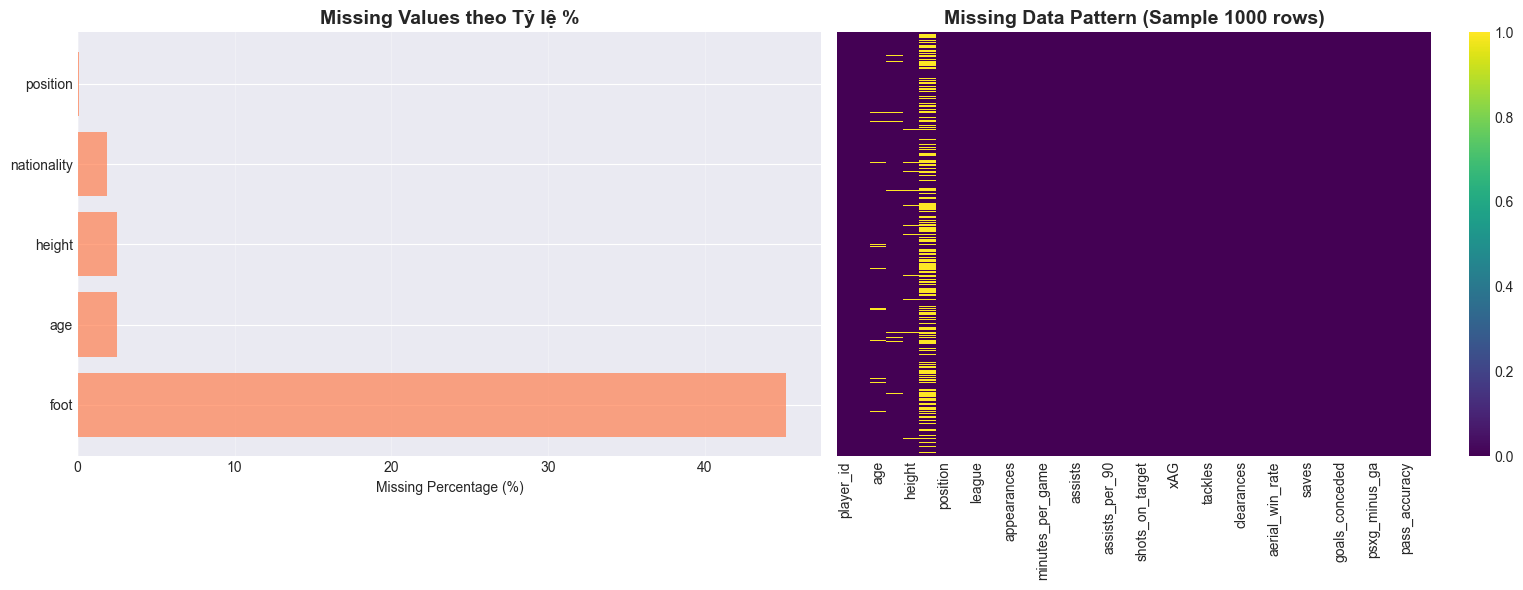


 PHÂN TÍCH NGUYÊN NHÂN MISSING VALUES:

   Thông tin cơ bản: age, height, nationality
      → Nguyên nhân: Dữ liệu thu thập được không đầy đủ
      → Giải pháp: Điền median (số) hoặc mode (phân loại), loại bỏ các cột không cần thiết


In [64]:
# Tính toán missing values
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df) * 100).round(2),
    'Data_Type': df.dtypes
})

# Lọc các cột có missing values
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values(
    'Missing_Percentage', ascending=False
)

if len(missing_df) > 0:
    print("\nCÁC CỘT CÓ MISSING VALUES:\n")
    print(missing_df.to_string(index=False))
    
    # Visualization
    if len(missing_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Bar chart
        axes[0].barh(missing_df['Column'], missing_df['Missing_Percentage'], 
                     color='coral', alpha=0.7)
        axes[0].set_xlabel('Missing Percentage (%)')
        axes[0].set_title('Missing Values theo Tỷ lệ %', fontsize=14, fontweight='bold')
        axes[0].grid(alpha=0.3, axis='x')
        
        # Heatmap (sample 1000 rows)
        sample_size = min(1000, len(df))
        sns.heatmap(df.sample(sample_size).isnull(), 
                   cbar=True, yticklabels=False, cmap='viridis', ax=axes[1])
        axes[1].set_title(f'Missing Data Pattern (Sample {sample_size} rows)', 
                         fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Phân tích nguyên nhân
    print("\n PHÂN TÍCH NGUYÊN NHÂN MISSING VALUES:")
    
    # Goalkeeper stats
    gk_stats = ['clean_sheets', 'saves', 'save_percentage', 'goals_conceded', 
                'goals_conceded_per_90', 'psxg_minus_ga']
    gk_missing = [col for col in gk_stats if col in missing_df['Column'].values]
    
    if gk_missing:
        print(f"\n   Chỉ số thủ môn: {', '.join(gk_missing)}")
        print(f"      → Nguyên nhân: Chỉ áp dụng cho thủ môn, các vị trí khác sẽ thiếu")
        print(f"      → Giải pháp: Điền 0 cho các vị trí không phải thủ môn")
    
    # Performance stats
    perf_stats = ['goals', 'assists', 'tackles', 'xG', 'xAG']
    perf_missing = [col for col in perf_stats if col in missing_df['Column'].values]
    
    if perf_missing:
        print(f"\n   Chỉ số thành tích: {', '.join(perf_missing)}")
        print(f"      → Nguyên nhân: Cầu thủ không thi đấu hoặc không có thành tích")
        print(f"      → Giải pháp: Điền 0 (có nghĩa là không có thành tích)")
    
    # Basic info
    basic_info = ['age', 'height', 'nationality']
    basic_missing = [col for col in basic_info if col in missing_df['Column'].values]
    
    if basic_missing:
        print(f"\n   Thông tin cơ bản: {', '.join(basic_missing)}")
        print(f"      → Nguyên nhân: Dữ liệu thu thập được không đầy đủ")
        print(f"      → Giải pháp: Điền median (số) hoặc mode (phân loại), loại bỏ các cột không cần thiết")
    
    # Target variable
    if 'market_value' in missing_df['Column'].values:
        print(f"\n   BIẾN MỤC TIÊU 'market_value' có missing values!")
        print(f"      → Giải pháp: LOẠI BỎ các dòng này (không thể dự đoán mà không có target)")
        
else:
    print("\n✅ KHÔNG CÓ MISSING VALUES TRONG DỮ LIỆU!")


### **5. Phân tích phân phối**

#### **5.1. Phân phối của biến mục tiêu (Market Value)**


                    💰 PHÂN TÍCH BIẾN MỤC TIÊU: MARKET_VALUE

📊 THỐNG KÊ MÔ TẢ:

count    11266.000000
mean         4.439271
std         11.175736
min          0.010000
25%          0.325000
50%          0.900000
75%          3.000000
max        200.000000
Name: market_value, dtype: float64

📈 CHỈ SỐ BỔ SUNG:
   - Q1 (25th percentile): 0.33 M€
   - Q3 (75th percentile): 3.00 M€
   - IQR: 2.67 M€
   - Skewness: 6.53
   - Kurtosis: 64.01
   - Outliers: 1541 (13.68%)


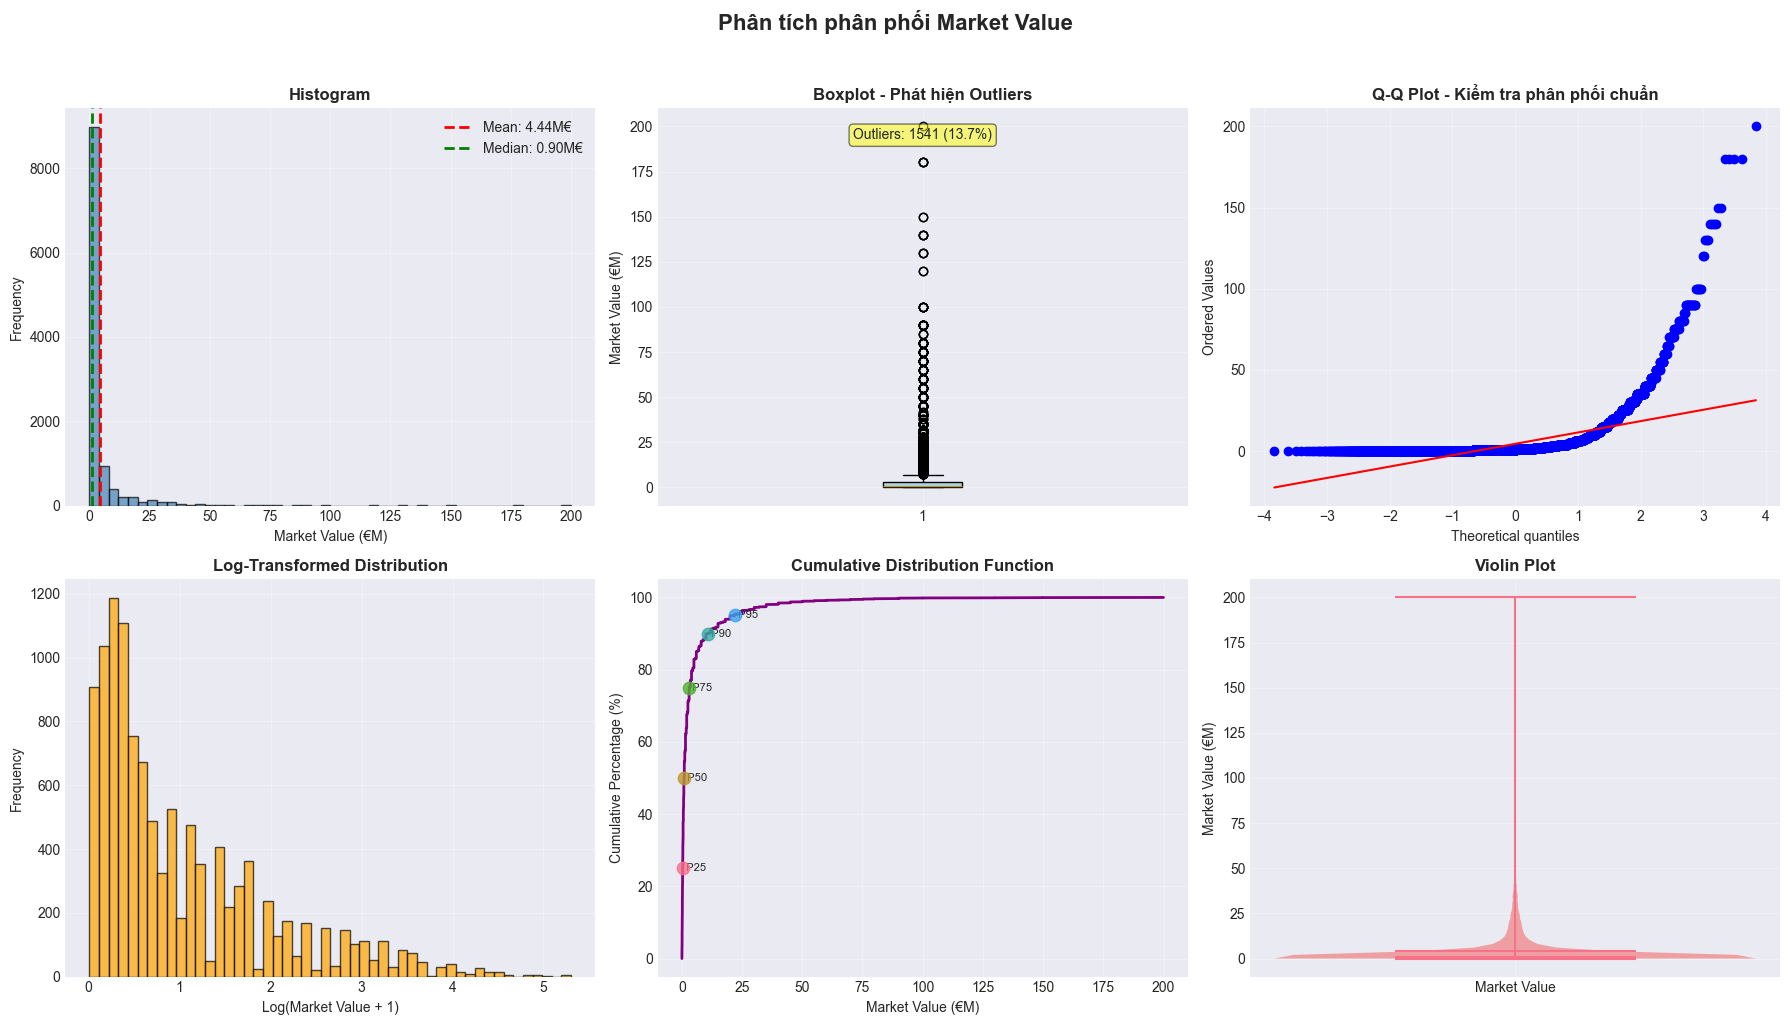

In [28]:
print("\n" + "="*100)
print(" "*20 + "💰 PHÂN TÍCH BIẾN MỤC TIÊU: MARKET_VALUE")
print("="*100)

# Thống kê mô tả
print("\n📊 THỐNG KÊ MÔ TẢ:\n")
print(df['market_value'].describe())

# Tính toán thêm
Q1 = df['market_value'].quantile(0.25)
Q3 = df['market_value'].quantile(0.75)
IQR = Q3 - Q1
outliers_count = len(df[(df['market_value'] < Q1 - 1.5*IQR) | 
                        (df['market_value'] > Q3 + 1.5*IQR)])

print(f"\n📈 CHỈ SỐ BỔ SUNG:")
print(f"   - Q1 (25th percentile): {Q1:.2f} M€")
print(f"   - Q3 (75th percentile): {Q3:.2f} M€")
print(f"   - IQR: {IQR:.2f} M€")
print(f"   - Skewness: {df['market_value'].skew():.2f}")
print(f"   - Kurtosis: {df['market_value'].kurtosis():.2f}")
print(f"   - Outliers: {outliers_count} ({outliers_count/len(df)*100:.2f}%)")

# %%
# Visualization - 6 plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Phân tích phân phối Market Value', fontsize=16, fontweight='bold', y=1.02)

# 1. Histogram
axes[0, 0].hist(df['market_value'].dropna(), bins=50, edgecolor='black', 
                alpha=0.7, color='steelblue')
axes[0, 0].axvline(df['market_value'].mean(), color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {df["market_value"].mean():.2f}M€')
axes[0, 0].axvline(df['market_value'].median(), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {df["market_value"].median():.2f}M€')
axes[0, 0].set_title('Histogram', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Market Value (€M)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Boxplot
box = axes[0, 1].boxplot(df['market_value'].dropna(), vert=True, patch_artist=True)
box['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_title('Boxplot - Phát hiện Outliers', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Market Value (€M)')
axes[0, 1].grid(alpha=0.3)
axes[0, 1].text(0.5, 0.95, f'Outliers: {outliers_count} ({outliers_count/len(df)*100:.1f}%)',
               transform=axes[0, 1].transAxes, ha='center', va='top',
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5), fontsize=10)

# 3. Q-Q Plot
stats.probplot(df['market_value'].dropna(), dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot - Kiểm tra phân phối chuẩn', fontsize=12, fontweight='bold')
axes[0, 2].grid(alpha=0.3)

# 4. Log transformation
log_values = np.log1p(df['market_value'].dropna())
axes[1, 0].hist(log_values, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Log-Transformed Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Log(Market Value + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(alpha=0.3)

# 5. Cumulative Distribution
sorted_values = np.sort(df['market_value'].dropna())
cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values) * 100
axes[1, 1].plot(sorted_values, cumulative, linewidth=2, color='purple')
axes[1, 1].set_title('Cumulative Distribution Function', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Market Value (€M)')
axes[1, 1].set_ylabel('Cumulative Percentage (%)')
axes[1, 1].grid(alpha=0.3)

# Add percentile markers
percentiles = [25, 50, 75, 90, 95]
for p in percentiles:
    val = np.percentile(df['market_value'].dropna(), p)
    axes[1, 1].scatter([val], [p], s=80, zorder=5, alpha=0.8)
    axes[1, 1].text(val, p, f' P{p}', fontsize=8, va='center')

# 6. Violin plot
parts = axes[1, 2].violinplot([df['market_value'].dropna()], vert=True, 
                               showmeans=True, showmedians=True)
for pc in parts['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)
axes[1, 2].set_title('Violin Plot', fontsize=12, fontweight='bold')
axes[1, 2].set_ylabel('Market Value (€M)')
axes[1, 2].set_xticks([1])
axes[1, 2].set_xticklabels(['Market Value'])
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

**Nhận xét về phân phối Market Value:**
 
- **Skewness**: Phân phối bị lệch phải mạnh (positive skew) → Đa số cầu thủ có giá trị thấp, một số ít có giá trị rất cao
- **Outliers**: Có nhiều outliers (cầu thủ siêu sao) → Đây là đặc điểm tự nhiên của thị trường chuyển nhượng
- **Log transformation**: Phân phối sau khi log transform gần với phân phối chuẩn hơn → Nên xem xét sử dụng khi modeling
- **Kurtosis**: Phân phối có đuôi dày → Nhiều giá trị cực trị

#### **5.2 Phân phối các biến số (Numerical Features)**


                         📊 PHÂN TÍCH CÁC BIẾN SỐ (NUMERICAL FEATURES)

📋 Tổng số biến số: 28

📈 BẢNG THỐNG KÊ CHI TIẾT:

                         count     mean      std   min     25%     50%  \
age                    10981.0    25.94     4.64  16.0   22.00   25.00   
height                 10982.0   181.65     7.12  69.0  177.00  182.00   
appearances            11266.0    20.26    25.64   0.0    7.00   17.00   
minutes_played         11266.0  1346.28  2061.90   0.0  280.00  960.00   
minutes_per_game       11266.0    55.75    26.54   0.0   36.00   60.20   
goals                  11266.0     4.97    10.34   0.0    1.00    2.00   
assists                11266.0     3.63     6.62   0.0    0.00    1.00   
goals_per_90           11266.0     7.19   116.03   0.0    0.03    0.15   
assists_per_90         11266.0     3.88    42.84   0.0    0.00    0.12   
shots                  11266.0     0.00     0.00   0.0    0.00    0.00   
shots_on_target        11266.0     0.00     0.00   0.0    0.00  

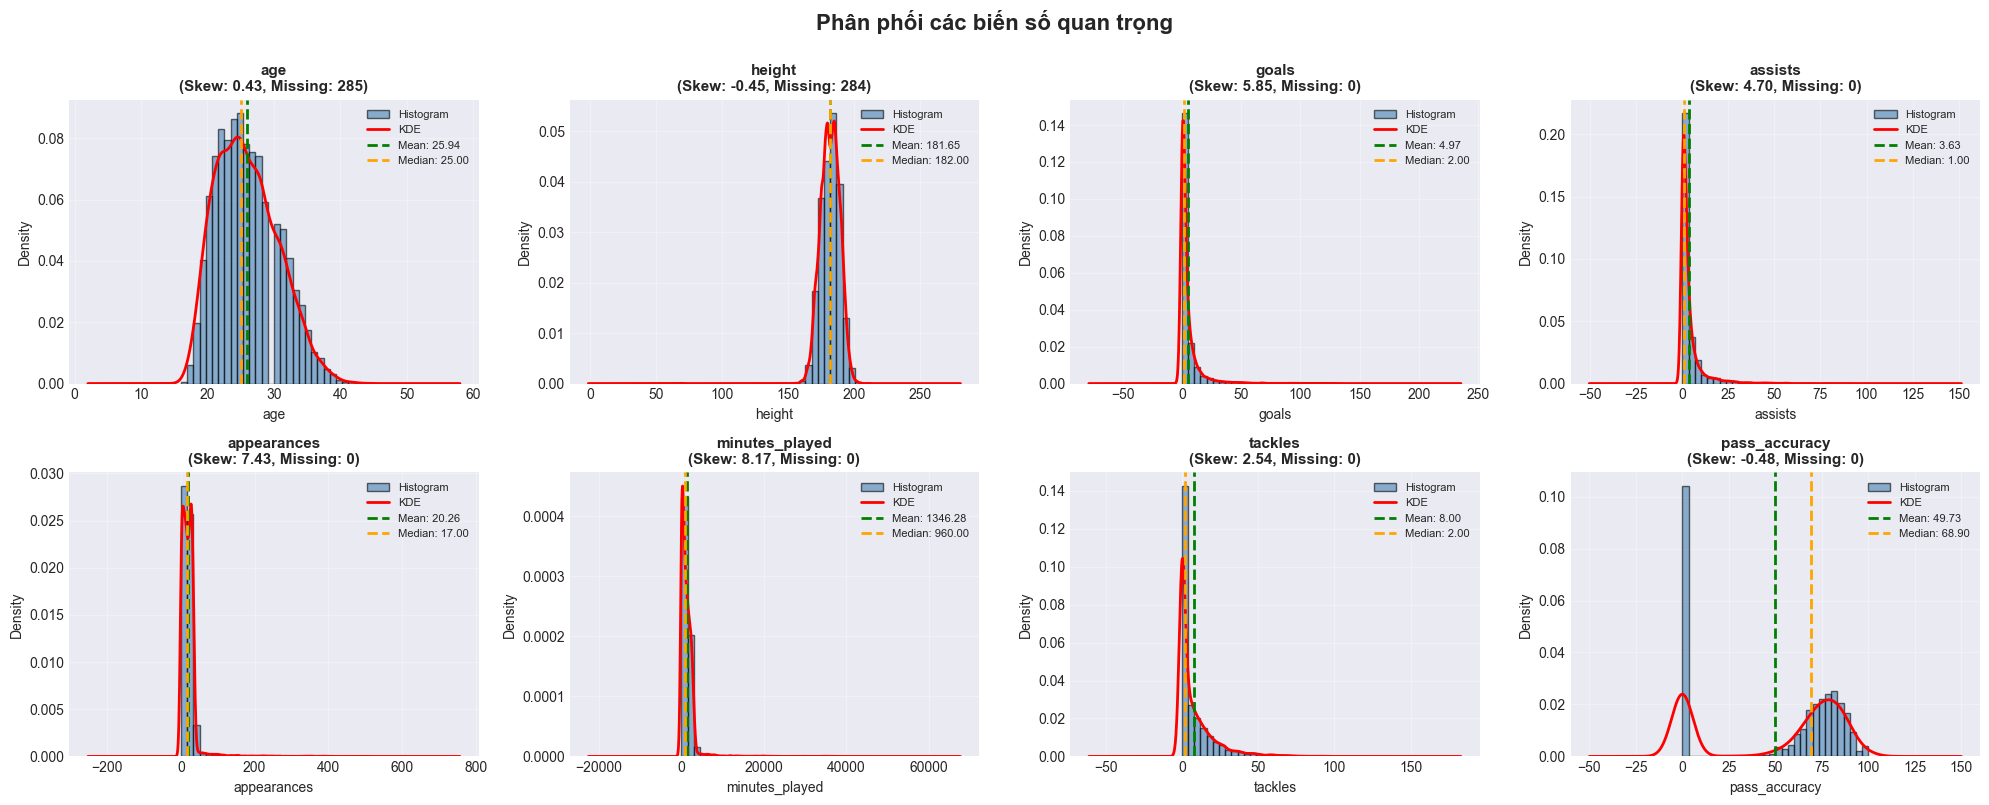

In [29]:
print("\n" + "="*100)
print(" "*25 + "📊 PHÂN TÍCH CÁC BIẾN SỐ (NUMERICAL FEATURES)")
print("="*100)

# Lấy các cột số (trừ ID và target)
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'player_id' in numerical_cols:
    numerical_cols.remove('player_id')
if 'market_value' in numerical_cols:
    numerical_cols.remove('market_value')

print(f"\n📋 Tổng số biến số: {len(numerical_cols)}")

# Tạo summary statistics
summary_stats = df[numerical_cols].describe().T
summary_stats['missing'] = df[numerical_cols].isnull().sum()
summary_stats['missing_pct'] = (df[numerical_cols].isnull().sum() / len(df) * 100).round(2)
summary_stats['skewness'] = df[numerical_cols].skew()
summary_stats['kurtosis'] = df[numerical_cols].kurtosis()

print("\n📈 BẢNG THỐNG KÊ CHI TIẾT:\n")
print(summary_stats.round(2))

# %%
# Visualization - Distributions of important variables
important_vars = ['age', 'height', 'goals', 'assists', 'appearances', 
                  'minutes_played', 'tackles', 'pass_accuracy']
important_vars = [v for v in important_vars if v in df.columns]

n_vars = len(important_vars)
n_cols = 4
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows*4))
fig.suptitle('Phân phối các biến số quan trọng', fontsize=16, fontweight='bold', y=1.00)
axes = axes.flatten() if n_rows > 1 else axes

for idx, col in enumerate(important_vars):
    ax = axes[idx]
    
    # Histogram + KDE
    data = df[col].dropna()
    ax.hist(data, bins=30, alpha=0.6, color='steelblue', 
            edgecolor='black', density=True, label='Histogram')
    
    # KDE
    if len(data) > 1 and data.std() > 0:
        data.plot(kind='kde', ax=ax, color='red', linewidth=2, label='KDE')
    
    # Statistics lines
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='green', linestyle='--', linewidth=2, 
               label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='orange', linestyle='--', linewidth=2, 
               label=f'Median: {median_val:.2f}')
    
    # Title and labels
    skew_val = data.skew()
    missing_val = df[col].isnull().sum()
    ax.set_title(f'{col}\n(Skew: {skew_val:.2f}, Missing: {missing_val})', 
                fontsize=11, fontweight='bold')
    ax.set_xlabel(col, fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=8, loc='best')
    ax.grid(alpha=0.3)

# Hide unused subplots
for idx in range(len(important_vars), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Nhận xét về các biến số:**

- **Age**: Phân phối tương đối cân đối, tập trung ở độ tuổi 22-28
- **Goals, Assists**: Phân phối lệch phải mạnh, nhiều cầu thủ có thành tích thấp
- **Appearances**: Phân phối đa dạng, phản ánh mức độ thi đấu khác nhau
- **Tackles**: Cao ở hậu vệ và tiền vệ phòng ngự, thấp ở tiền đạo

#### **5.3. Correlation Analysis**


                         🔗 PHÂN TÍCH CORRELATION VỚI MARKET VALUE

📊 TOP 10 FEATURES CÓ CORRELATION CAO NHẤT:

pass_accuracy     0.259380
xAG               0.206475
xG                0.186935
tackles           0.105260
minutes_played    0.081549
appearances       0.075942
assists           0.065387
goals             0.063184
goals_per_90      0.004755
assists_per_90   -0.004914
Name: market_value, dtype: float64

📊 TOP 10 FEATURES CÓ CORRELATION THẤP NHẤT:

xG                0.186935
tackles           0.105260
minutes_played    0.081549
appearances       0.075942
assists           0.065387
goals             0.063184
goals_per_90      0.004755
assists_per_90   -0.004914
height           -0.005040
age              -0.067348
Name: market_value, dtype: float64


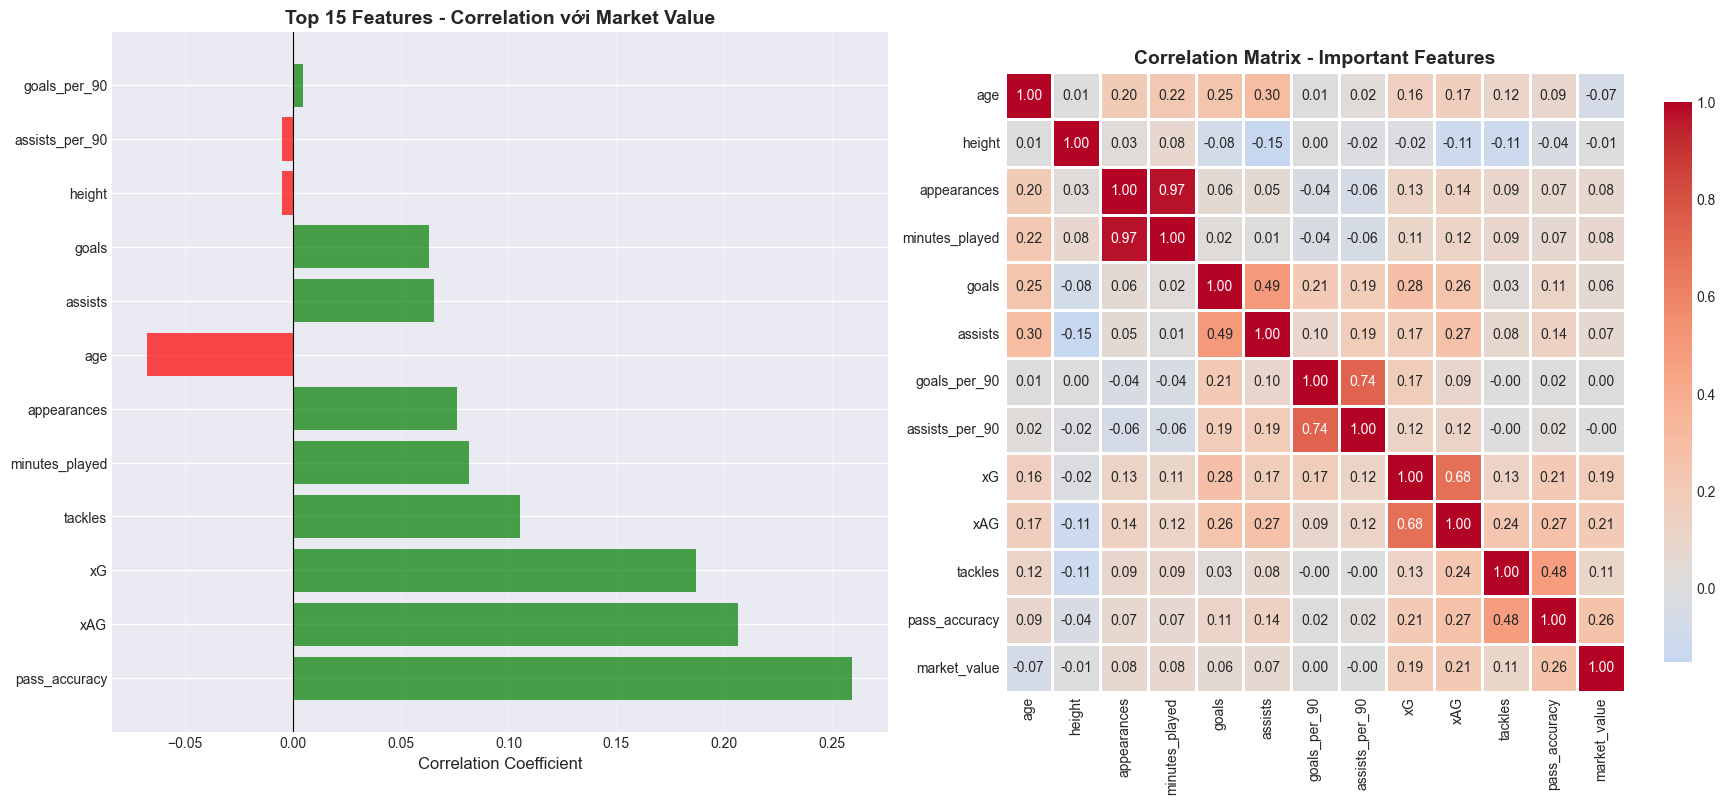

In [30]:
# Tính correlation với market_value
print("\n" + "="*100)
print(" "*25 + "🔗 PHÂN TÍCH CORRELATION VỚI MARKET VALUE")
print("="*100)

# Chọn các features quan trọng
important_features = ['age', 'height', 'appearances', 'minutes_played', 'goals', 
                      'assists', 'goals_per_90', 'assists_per_90', 'xG', 'xAG',
                      'tackles', 'pass_accuracy', 'market_value']
important_features = [f for f in important_features if f in df.columns]

# Calculate correlation
correlation_with_target = df[important_features].corr()['market_value'].drop('market_value')
correlation_with_target = correlation_with_target.sort_values(ascending=False)

print("\n📊 TOP 10 FEATURES CÓ CORRELATION CAO NHẤT:\n")
print(correlation_with_target.head(10))

print("\n📊 TOP 10 FEATURES CÓ CORRELATION THẤP NHẤT:\n")
print(correlation_with_target.tail(10))

# %%
# Visualization - Correlation heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# 1. Bar chart - Correlation with target
top_n = 15
top_corr = correlation_with_target.abs().nlargest(top_n)
colors = ['green' if correlation_with_target[feat] > 0 else 'red' for feat in top_corr.index]

axes[0].barh(range(len(top_corr)), [correlation_with_target[feat] for feat in top_corr.index], 
             color=colors, alpha=0.7)
axes[0].set_yticks(range(len(top_corr)))
axes[0].set_yticklabels(top_corr.index)
axes[0].set_xlabel('Correlation Coefficient', fontsize=12)
axes[0].set_title(f'Top {top_n} Features - Correlation với Market Value', 
                 fontsize=14, fontweight='bold')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].grid(alpha=0.3, axis='x')

# 2. Heatmap - Correlation matrix
corr_matrix = df[important_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=axes[1])
axes[1].set_title('Correlation Matrix - Important Features', 
                 fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

**Nhận xét về Correlation:**

- Các chỉ số tấn công (goals, assists, xG) có correlation dương mạnh với market_value
- Thời gian thi đấu (appearances, minutes_played) cũng có ảnh hưởng đáng kể
- Tuổi có thể có correlation âm (cầu thủ già giá trị giảm) hoặc dương (kinh nghiệm)
- Cần kiểm tra multicollinearity giữa các features tương quan cao

#### **5.4 Phân tích các biến phân loại (Categorical Features)**


                    📁 PHÂN TÍCH CÁC BIẾN PHÂN LOẠI (CATEGORICAL FEATURES)

📊 THỐNG KÊ CÁC BIẾN PHÂN LOẠI:

      Column  Unique_Count    Most_Common  Most_Common_Count  Most_Common_Pct  Missing  Missing_Pct
 nationality           150      Argentina                995             8.83      212         1.88
        foot             3          Right               4403            39.08     5086        45.14
    position             9             MF               3019            26.80        6         0.05
current_club           381           Ajax                 47             0.42        0         0.00
      league            22 Argentine Liga                980             8.70        0         0.00

⚠️  CẢNH BÁO VỀ HIGH CARDINALITY:
   ✅ nationality: 150 unique values (1.3%) - OK
   ✅ foot: 3 unique values (0.0%) - OK
   ✅ position: 9 unique values (0.1%) - OK
   ✅ current_club: 381 unique values (3.4%) - OK
   ✅ league: 22 unique values (0.2%) - OK


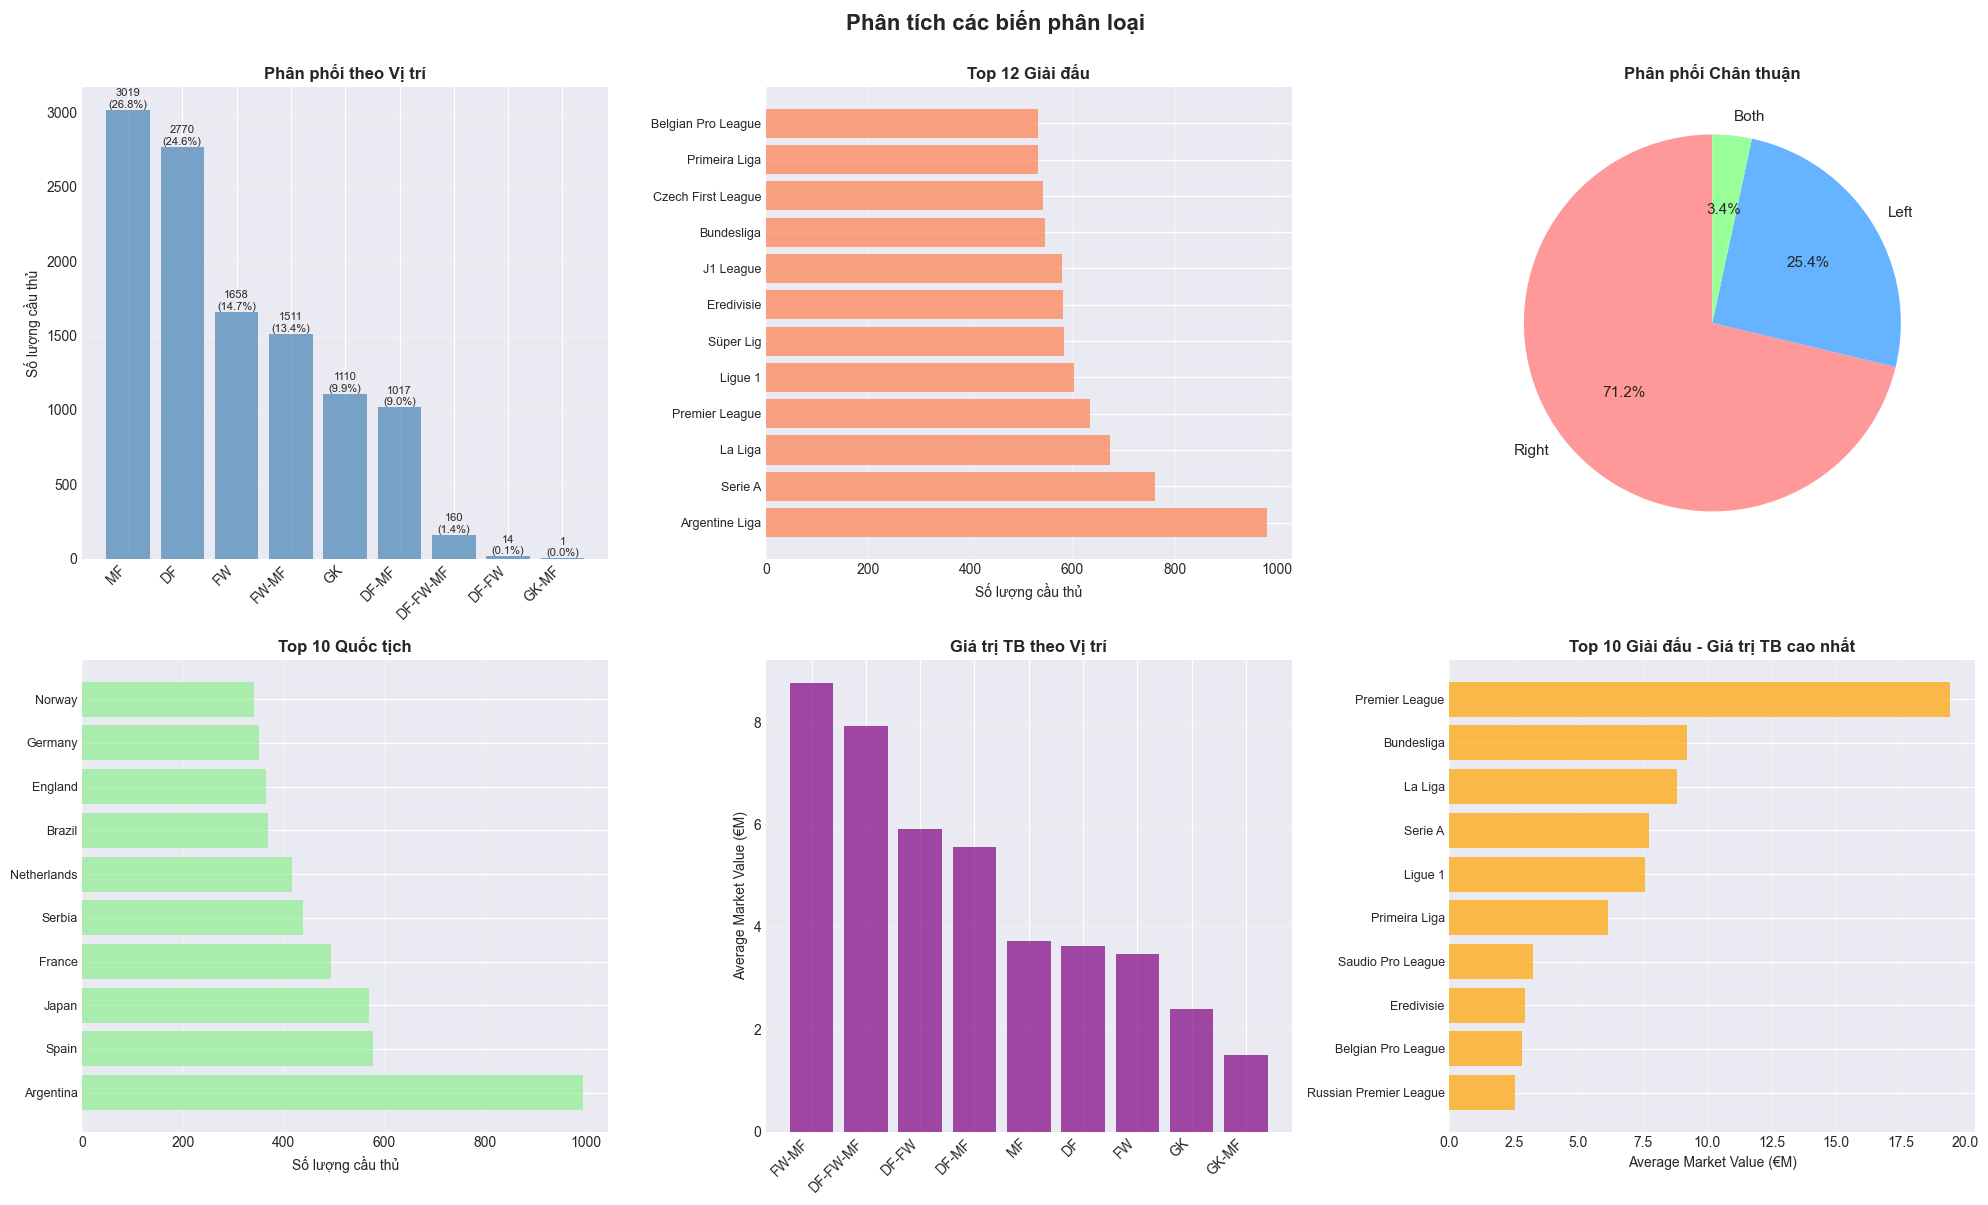

In [31]:
print("\n" + "="*100)
print(" "*20 + "📁 PHÂN TÍCH CÁC BIẾN PHÂN LOẠI (CATEGORICAL FEATURES)")
print("="*100)

categorical_cols = ['nationality', 'foot', 'position', 'current_club', 'league']
categorical_cols = [col for col in categorical_cols if col in df.columns]

# Summary statistics
cat_summary = pd.DataFrame({
    'Column': categorical_cols,
    'Unique_Count': [df[col].nunique() for col in categorical_cols],
    'Most_Common': [df[col].mode()[0] if len(df[col].mode()) > 0 else 'N/A' 
                    for col in categorical_cols],
    'Most_Common_Count': [df[col].value_counts().iloc[0] if len(df[col]) > 0 else 0 
                          for col in categorical_cols],
    'Most_Common_Pct': [(df[col].value_counts().iloc[0] / len(df) * 100).round(2) 
                        if len(df[col]) > 0 else 0 for col in categorical_cols],
    'Missing': [df[col].isnull().sum() for col in categorical_cols],
    'Missing_Pct': [(df[col].isnull().sum() / len(df) * 100).round(2) 
                    for col in categorical_cols]
})

print("\n📊 THỐNG KÊ CÁC BIẾN PHÂN LOẠI:\n")
print(cat_summary.to_string(index=False))

# Cardinality warning
print("\n⚠️  CẢNH BÁO VỀ HIGH CARDINALITY:")
for col in categorical_cols:
    unique_count = df[col].nunique()
    unique_ratio = unique_count / len(df) * 100
    
    if unique_ratio > 50:
        print(f"   🔴 {col}: {unique_count} unique values ({unique_ratio:.1f}%) - RẤT CAO!")
        print(f"       💡 Đề xuất: Target encoding hoặc loại bỏ feature")
    elif unique_ratio > 20:
        print(f"   🟡 {col}: {unique_count} unique values ({unique_ratio:.1f}%) - CAO")
        print(f"       💡 Đề xuất: Frequency encoding hoặc nhóm categories hiếm")
    else:
        print(f"   ✅ {col}: {unique_count} unique values ({unique_ratio:.1f}%) - OK")

# %%
# Visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Phân tích các biến phân loại', fontsize=16, fontweight='bold', y=1.00)
axes = axes.flatten()

# 1. Position distribution
if 'position' in df.columns:
    pos_counts = df['position'].value_counts()
    axes[0].bar(range(len(pos_counts)), pos_counts.values, color='steelblue', alpha=0.7)
    axes[0].set_xticks(range(len(pos_counts)))
    axes[0].set_xticklabels(pos_counts.index, rotation=45, ha='right')
    axes[0].set_title('Phân phối theo Vị trí', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Số lượng cầu thủ')
    axes[0].grid(alpha=0.3, axis='y')
    
    for i, v in enumerate(pos_counts.values):
        axes[0].text(i, v, f'{v}\n({v/len(df)*100:.1f}%)', 
                    ha='center', va='bottom', fontsize=8)

# 2. League distribution
if 'league' in df.columns:
    league_counts = df['league'].value_counts().head(12)
    axes[1].barh(range(len(league_counts)), league_counts.values, color='coral', alpha=0.7)
    axes[1].set_yticks(range(len(league_counts)))
    axes[1].set_yticklabels(league_counts.index, fontsize=9)
    axes[1].set_title('Top 12 Giải đấu', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Số lượng cầu thủ')
    axes[1].grid(alpha=0.3, axis='x')

# 3. Foot preference
if 'foot' in df.columns:
    foot_counts = df['foot'].value_counts()
    colors_foot = ['#ff9999', '#66b3ff', '#99ff99'][:len(foot_counts)]
    wedges, texts, autotexts = axes[2].pie(foot_counts.values, labels=foot_counts.index, 
                                            autopct='%1.1f%%', colors=colors_foot,
                                            startangle=90, textprops={'fontsize': 11})
    axes[2].set_title('Phân phối Chân thuận', fontsize=12, fontweight='bold')

# 4. Top 10 Nationalities
if 'nationality' in df.columns:
    nat_counts = df['nationality'].value_counts().head(10)
    axes[3].barh(range(len(nat_counts)), nat_counts.values, color='lightgreen', alpha=0.7)
    axes[3].set_yticks(range(len(nat_counts)))
    axes[3].set_yticklabels(nat_counts.index, fontsize=9)
    axes[3].set_title('Top 10 Quốc tịch', fontsize=12, fontweight='bold')
    axes[3].set_xlabel('Số lượng cầu thủ')
    axes[3].grid(alpha=0.3, axis='x')

# 5. Position vs Market Value
if 'position' in df.columns and 'market_value' in df.columns:
    position_value = df.groupby('position')['market_value'].mean().sort_values(ascending=False)
    axes[4].bar(range(len(position_value)), position_value.values, color='purple', alpha=0.7)
    axes[4].set_xticks(range(len(position_value)))
    axes[4].set_xticklabels(position_value.index, rotation=45, ha='right')
    axes[4].set_title('Giá trị TB theo Vị trí', fontsize=12, fontweight='bold')
    axes[4].set_ylabel('Average Market Value (€M)')
    axes[4].grid(alpha=0.3, axis='y')

# 6. League vs Market Value
if 'league' in df.columns and 'market_value' in df.columns:
    league_value = df.groupby('league')['market_value'].mean().nlargest(10).sort_values(ascending=True)
    axes[5].barh(range(len(league_value)), league_value.values, color='orange', alpha=0.7)
    axes[5].set_yticks(range(len(league_value)))
    axes[5].set_yticklabels(league_value.index, fontsize=9)
    axes[5].set_title('Top 10 Giải đấu - Giá trị TB cao nhất', fontsize=12, fontweight='bold')
    axes[5].set_xlabel('Average Market Value (€M)')
    axes[5].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

 **Nhận xét về các biến phân loại:**
 
- **Position**: Phân phối tương đối đều giữa các vị trí
- **League**: Tập trung ở các giải đấu lớn (Big 5 leagues)
- **Nationality**: Đa dạng quốc tịch, phản ánh tính quốc tế của bóng đá
- **High Cardinality**: current_club và nationality có quá nhiều unique values → Cần xử lý đặc biệt

### **6. Tổng kết phát hiện và khuyến nghị**